считываем данные из student-mat.csv

In [9]:
import pandas as pd
import numpy as np
import math

csv_file_path = "student-mat.csv"

df = pd.read_csv(csv_file_path, sep=";")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 395 entries, 0 to 394
Data columns (total 33 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   school      395 non-null    object
 1   sex         395 non-null    object
 2   age         395 non-null    int64 
 3   address     395 non-null    object
 4   famsize     395 non-null    object
 5   Pstatus     395 non-null    object
 6   Medu        395 non-null    int64 
 7   Fedu        395 non-null    int64 
 8   Mjob        395 non-null    object
 9   Fjob        395 non-null    object
 10  reason      395 non-null    object
 11  guardian    395 non-null    object
 12  traveltime  395 non-null    int64 
 13  studytime   395 non-null    int64 
 14  failures    395 non-null    int64 
 15  schoolsup   395 non-null    object
 16  famsup      395 non-null    object
 17  paid        395 non-null    object
 18  activities  395 non-null    object
 19  nursery     395 non-null    object
 20  higher    

для облегчения подсчетов переводим в матричный вил и разделяем на шкалы порядка, наименований и абсолютную шкалу

In [10]:
matrix_df = df.values.T

numeric_df = []
categorical_df = []
absolute_df = ['age', 'absences']

for column in df.columns:
    if df[column].dtype in ['int64', 'float64'] and column not in absolute_df:
        numeric_df.append(column)
    elif column not in absolute_df:
        categorical_df.append(column)

num_rows_df = df.shape[0]
print(f"Количество строк датасета: {num_rows_df}")

num_columns_df = df.shape[1]
print(f"Количество столбцов датасета: {num_columns_df}")

num_columns_numeric_df = len(numeric_df)
print(f"Данные с шкалой порядка (количество столбцов: {num_columns_numeric_df})")
print(numeric_df)

num_columns_categorical_df = len(categorical_df)
print(f"\nДанные с шкалой наименований (количество столбцов: {num_columns_categorical_df})")
print(categorical_df)

num_columns_absolute_df = len(absolute_df)
print(f"\nДанные с абсолютной шкалой (количество столбцов: {num_columns_absolute_df})") 
print(absolute_df)


Количество строк датасета: 395
Количество столбцов датасета: 33
Данные с шкалой порядка (количество столбцов: 14)
['Medu', 'Fedu', 'traveltime', 'studytime', 'failures', 'famrel', 'freetime', 'goout', 'Dalc', 'Walc', 'health', 'G1', 'G2', 'G3']

Данные с шкалой наименований (количество столбцов: 17)
['school', 'sex', 'address', 'famsize', 'Pstatus', 'Mjob', 'Fjob', 'reason', 'guardian', 'schoolsup', 'famsup', 'paid', 'activities', 'nursery', 'higher', 'internet', 'romantic']

Данные с абсолютной шкалой (количество столбцов: 2)
['age', 'absences']


считываем сколько у нас строк в датафрейме(количество объектов), формируем матрицу попарных расстояний с помощью метрик
для наменовний:
d(i,l) = 0, если (Xi = X и Xl = X) или (Xi = X И Xl = X)
d(i,l) = 1, если (Xi = X и Xl ≠ X) или (Xi ≠ X и Xl = X)

для порядка:
d(i,l) = 0, если (Xi > X и Xl > X) или (Xi < X и Xl < X) или (Xi = X и Xl = X)
d(i,l) = 1, если (Xi > X и Xl < X) или (Xi < X И Xl > X)
d(i,l) = 0.5, если (Xi >< X и Xl = X) или (Xi = X И Xl >< X)

для абсолютной:
d(i,l) = 0, если |(Xi - Xl)| / (X.max - X.min)

Пояснение, X пробегает все значения в столбце, а Xi это значение 1 объекта, Xl значени 2 объекта

Так как расстояния должны быть [0; 1], то нормируем их деля на количество всех объектов

В конце по формуле из группы считаем расстояние между объектами

In [11]:
matrix_pairwise_distances_df = np.zeros((num_rows_df, num_rows_df), dtype=np.float64)

def calc_categorical(i, l , column):
    d = np.float64(0)
    xi = column[i]
    xl = column[l]

    for x in column:
        if(((xi == x) and (xl == x)) or ((xi != x) and (xl != x))):
            d += 0
        else:
            d += 1

    d = d / np.float64(num_rows_df)  
    return d

def calc_numeric(i, l , column):
    d = np.float64(0)
    xi = column[i]
    xl = column[l]

    for x in column:
        if(((xi > x) and (xl > x)) or ((xi < x) and (xl < x)) or ((xi == x) and (xl == x))):
            d += 0
        elif(((xi > x) and (xl < x)) or ((xi < x) and (xl > x))):
            d += 1
        else:
            d += 0.5

    d = d / np.float64(num_rows_df)  
    return d

def calc_absolute(i, l , column):
    d = np.float64(0)
    xi = column[i]
    xl = column[l]

    d = abs(xi - xl) / (np.float64(max(column)) - np.float64(min(column)))  
    return d

for i in range(0, num_rows_df - 1):
    for l in range(i + 1, num_rows_df):
        t = 0
        d = np.float64(0)

        for column in df.columns:
            if(column in categorical_df):
                d += math.pow(calc_categorical(i, l, matrix_df[t]), 2)
            elif(column in absolute_df):
                d += math.pow(calc_absolute(i, l, matrix_df[t]), 2)
            else:
                d += math.pow(calc_numeric(i, l, matrix_df[t]), 2)
            t += 1
        
        matrix_pairwise_distances_df[i][l] = math.sqrt(d) / math.sqrt(num_columns_df)
        matrix_pairwise_distances_df[l][i] = matrix_pairwise_distances_df[i][l]

pairwise_distances_df = pd.DataFrame(matrix_pairwise_distances_df)
csv_file_path = "matrix_pairwise_distances_df.csv"
pairwise_distances_df.to_csv(csv_file_path, sep=';', index=False)



In [12]:
print(matrix_pairwise_distances_df[5][20])

print(matrix_pairwise_distances_df[27][116])

0.39167036197519683
0.47369629105456795


унимодальная компактность

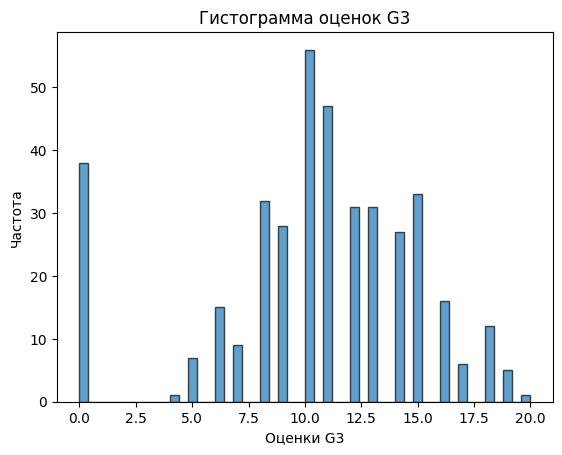

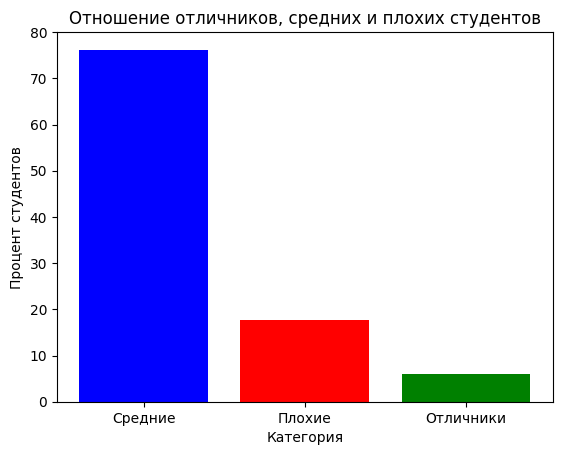

In [13]:
import matplotlib.pyplot as plt
from scipy import stats

df_unimodality = df.copy()
fig, ax = plt.subplots()

ax.hist(df['G3'], bins=50, edgecolor='black', alpha=0.7)

ax.set_xlabel('Оценки G3')
ax.set_ylabel('Частота')
ax.set_title('Гистограмма оценок G3')

plt.show()

G3 = df['G3'].values.reshape(-1, 1)
top = 17  
middle = 8  

def classify_students(score, top, middle):
    if score >= top:
        return 'Отличники'
    elif score >= middle:
        return 'Средние'
    else:
        return 'Плохие'

df_unimodality['Category'] = df_unimodality['G3'].apply(classify_students, args=(top, middle))
category_counts = df_unimodality['Category'].value_counts()

total_students = len(df_unimodality)
category_percentages = (category_counts / total_students) * 100

# Создайте гистограмму процентного соотношения
plt.bar(category_percentages.index, category_percentages.values, color=['blue', 'red', 'green'])
plt.xlabel('Категория')
plt.ylabel('Процент студентов')
plt.title('Отношение отличников, средних и плохих студентов')

plt.show()


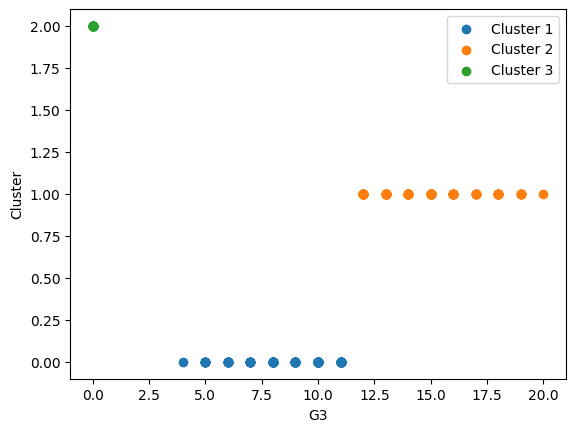

Cluster 1: Min = 4, Max = 11
Cluster 2: Min = 12, Max = 20
Cluster 3: Min = 0, Max = 0


In [14]:
G3 = df['G3'].values.reshape(-1, 1)

R = 6

def get_cluster_center(cluster):
    return np.mean(cluster, axis=0)

def forel_clustering(data, R):
    clusters = []

    while len(data) > 0:
        center = data[0]  
        cluster = [center]

        for point in data:
            if np.linalg.norm(point - center) < R:
                cluster.append(point)

        data = [point for point in data if point not in cluster]

        if cluster:
            clusters.append(cluster)

    return clusters

resulting_clusters = forel_clustering(G3, R)

for i, cluster in enumerate(resulting_clusters):
    y = [i] * len(cluster)  
    plt.scatter(cluster, y, label=f'Cluster {i + 1}')

plt.xlabel('G3')
plt.ylabel('Cluster')
plt.legend()
plt.show()


for i, cluster in enumerate(resulting_clusters):
    cluster_data = np.array(cluster)
    min_value = np.min(cluster_data)
    max_value = np.max(cluster_data)
    print(f"Cluster {i + 1}: Min = {min_value}, Max = {max_value}")

In [15]:
G3 = df['G3'].values.reshape(-1, 1)
top = 17  
middle = 8  

top_mark = []
middle_mark = []
bottom_mark = []

for i in range(len(G3)):
    if G3[i] >= top:
        top_mark.append(i)
    elif G3[i] >= middle:
        middle_mark.append(i)
    else:
        bottom_mark.append(i)

def calc_avg_mark(samples):
    ptr = 0
    count = 0
    for i in samples:
        for j in samples[i:]:
            ptr += matrix_pairwise_distances_df[i][j]
            count += 1
    return ptr / count

print(f"Высшая средняя оценка: {calc_avg_mark(top_mark)}")
print(f"Средняя средни средних оценок: {calc_avg_mark(middle_mark)}")
print(f"Низшая средняя оценка: {calc_avg_mark(bottom_mark)}")
print(f"Средняя среди всех средних оценок: {calc_avg_mark(range(len(G3)))}")


Высшая средняя оценка: 0.43736511444860177
Средняя средни средних оценок: 0.47053059624355
Низшая средняя оценка: 0.4777465469446674
Средняя среди всех средних оценок: 0.4742699160289717


Полимодальная компактность

c:\Users\Alena\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\Alena\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\Alena\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\Alena\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value 

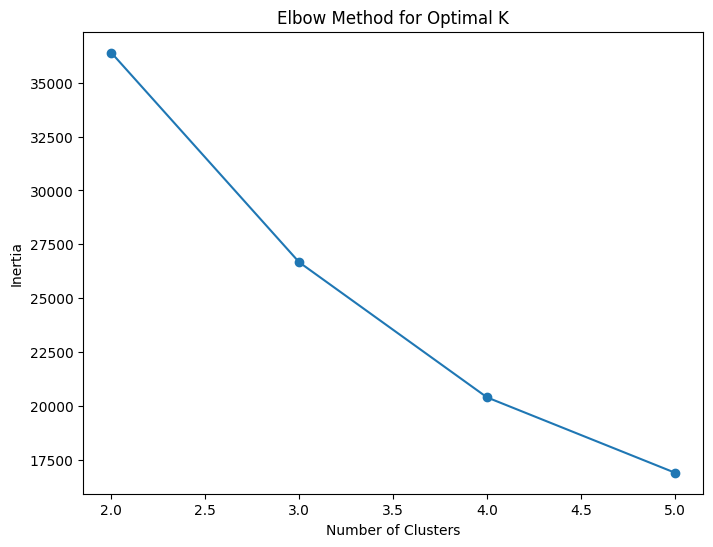

In [16]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

binary_arr = ['school', 'sex', 'address', 'famsize', 'Pstatus', 
'schoolsup', 'famsup', 'paid', 'activities', 'nursery', 'higher', 'internet', 'romantic',
'Mjob_teacher', 'Mjob_health', 'Mjob_services', 'Mjob_at_home', 'Mjob_other',
'Fjob_teacher', 'Fjob_health', 'Fjob_services', 'Fjob_at_home', 'Fjob_other',
'reason_home', 'reason_reputation', 'reason_course', 'reason_other',
'guardian_mother', 'guardian_father', 'guardian_other']

df_polymodal = pd.get_dummies(df, columns=['Mjob', 'Fjob', 'reason', 'guardian'])
for binary in binary_arr:
    df_polymodal[binary] = df_polymodal[binary].astype('category')
    df_polymodal[binary] = df_polymodal[binary].cat.codes

inertia = []

for n_clusters in range(2, 6):
    kmeans = KMeans(n_clusters=n_clusters, random_state=0)
    kmeans.fit(df_polymodal)
    inertia.append(kmeans.inertia_)

plt.figure(figsize=(8, 6))
plt.plot(range(2, 6), inertia, marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal K')
plt.show()

отсюда заметно что оптимальное количество клатеров 4

In [18]:
optimal_n_clusters = 4  
kmeans = KMeans(n_clusters=optimal_n_clusters, random_state=0)
kmeans.fit(df_polymodal)
y_pred = kmeans.fit_predict(df_polymodal)

array = []
for i in df['G3']:
    if i < 5:
        array.append(0)
    elif i < 11:
        array.append(1)
    elif i < 17:
        array.append(2)
    else: 
        array.append(3)
df_polymodal['gradeclass'] = array

d = {'Target': df_polymodal['gradeclass'], 'Prediction' : y_pred}


result = pd.DataFrame(d, columns = ['Target', 'Prediction'])

comparison = np.where(result['Target'] == result['Prediction'], True, False)
result['Comparison'] = comparison
result['Comparison'].value_counts(normalize = True).round(2)

c:\Users\Alena\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\Alena\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Comparison
False    0.75
True     0.25
Name: proportion, dtype: float64

локальная компактность

In [8]:
result = 0

for i in range(len(matrix_pairwise_distances_df)):
    nearest_obj_idx = np.argmin(np.delete(matrix_pairwise_distances_df[i], i))
    if nearest_obj_idx >= i:
        nearest_obj_idx += 1

    G3_i_value = df['G3'].iloc[i]
    G3_nearest_obj_value = df['G3'].iloc[nearest_obj_idx]

    if(G3_i_value < middle and G3_nearest_obj_value < middle): 
        result += 1

    elif((G3_i_value < top and G3_nearest_obj_value < top) 
    and
    (G3_i_value >= middle and G3_nearest_obj_value >= middle) 
    ):
        result += 1

    elif((G3_i_value < 21 and G3_nearest_obj_value < 21) 
    and
    (G3_i_value >= top and G3_nearest_obj_value >= top) 
    ):
        result += 1

local_compactness_percentage = (result / len(matrix_pairwise_distances_df)) * 100
print(f"Процент локальной компактности: {local_compactness_percentage:.2f}%")

Процент локальной компактности: 72.41%


по моему мнению если guardian = father то оценка в пределах от 6 до 15

In [19]:
father_guardian_students = df[df['guardian'] == 'father']

average_grade_father_guardian = father_guardian_students['G3'].mean()

students_in_range = father_guardian_students[(father_guardian_students['G3'] >= 6) & (father_guardian_students['G3'] <= 15)]
percentage_in_range = (len(students_in_range) / len(father_guardian_students)) * 100

print(f'Средняя оценка для студентов с отцом в качестве опекуна: {average_grade_father_guardian:.2f}')
print(f'Процент студентов с отцом в качестве опекуна, находящихся в диапазоне от 6 до 15: {percentage_in_range:.2f}%')

Средняя оценка для студентов с отцом в качестве опекуна: 10.69
Процент студентов с отцом в качестве опекуна, находящихся в диапазоне от 6 до 15: 78.89%


потенциальная опровержимость с помощью бутстрапа

In [22]:
df_bootstrap = df.copy()

n_iterations = 1000

results = []

for _ in range(n_iterations):
    
    bootstrap_sample = df_bootstrap.sample(frac=1, replace=True)
    
    father_guardian_students = bootstrap_sample[bootstrap_sample['guardian'] == 'father']
    average_grade_father_guardian = father_guardian_students['G3'].mean()
    students_in_range = father_guardian_students[(father_guardian_students['G3'] >= 6) & (father_guardian_students['G3'] <= 15)]
    percentage_in_range = (len(students_in_range) / len(father_guardian_students)) * 100
    
    
    results.append((average_grade_father_guardian, percentage_in_range))

std_deviation = np.std([result[0] for result in results])

print(f"Стандартное отклонение: {std_deviation:.2f}")

Стандартное отклонение: 0.48
